In [564]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('bbc-text.csv')


print(df.head())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


In [565]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['text']
y = df['category']

#list of text
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

# Learn the vocabulary and IDF weights from the training text (fit),
# then convert each training document into a TF-IDF numeric vector (transform).
X_train = tfidf.fit_transform(X_train_raw).toarray()
X_test = tfidf.transform(X_test_raw).toarray()

print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

Data split into 1780 training and 445 testing samples.


In [566]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Find the majority class in the training set
majority_class = y_train.value_counts().idxmax()
print(f"The majority class is: {majority_class}")

# Predict the majority class for all test samples
y_pred_simple = [majority_class] * len(y_test)

# Compute metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_simple):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_simple, average='weighted', zero_division=0):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_simple, average='weighted', zero_division=0):.4f}")

# Recall for the 'sport' class only
print(f"Recall (sport): {recall_score(y_test, y_pred_simple, labels=['sport'], average=None)[0]:.4f}")

The majority class is: sport
Accuracy: 0.2427
Precision (weighted): 0.0589
Recall (weighted): 0.2427
Recall (sport): 1.0000


In [567]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Create a keyword dictionary for each category using TF-IDF
# We select the words with the highest importance scores for each class
tfidf_gen = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf_gen.fit_transform(X_train_raw)
words = np.array(tfidf_gen.get_feature_names_out())

category_dictionaries = {}

for cat in y_train.unique():
    # Find indices of documents belonging to the specific category
    cat_indices = np.where(y_train == cat)[0]

    # Calculate the mean TF-IDF score for each word in this category
    cat_means = np.mean(X_train_tfidf[cat_indices], axis=0).A1

    # Select the top 20 words with the highest mean scores
    top_indices = cat_means.argsort()[-20:]
    category_dictionaries[cat] = set(words[top_indices])

    # Log the top words for verification
    print(f"Top words for {cat}: {list(category_dictionaries[cat])[:5]}...")

# 2. Define a prediction function based on dictionary overlap
def predict_by_dictionary(text):
    # Convert text to lowercase and split into a set of words
    text_words = set(text.lower().split())
    scores = {}

    for cat, dict_words in category_dictionaries.items():
        # Count how many keywords from the category dictionary appear in the text
        scores[cat] = len(text_words.intersection(dict_words))

    # Return the category with the highest overlap count
    return max(scores, key=scores.get)

# 3. Evaluate the model on the test set and calculate metrics (Section 11)
y_pred_dict = X_test_raw.apply(predict_by_dictionary)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_dict):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_dict, average='weighted', zero_division=0):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_dict, average='weighted', zero_division=0):.4f}")

Top words for tech: ['phone', 'internet', 'new', 'broadband', 'digital']...
Top words for politics: ['plans', 'secretary', 'tory', 'government', 'lord']...
Top words for sport: ['win', 'coach', 'players', 'team', 'club']...
Top words for business: ['2004', 'yukos', 'growth', 'market', 'government']...
Top words for entertainment: ['film', 'awards', 'actress', 'album', 'best']...

Accuracy: 0.8831
Precision (weighted): 0.8861
Recall (weighted): 0.8831


In [568]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Setting a seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in some operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 1. Prepare Tensors
# Convert TF-IDF matrices (X_train, X_test) to float32 tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Convert labels (y) to numerical values (0 to 4)
category_map = {cat: i for i, cat in enumerate(y_train.unique())}
y_train_num = y_train.map(category_map).values
y_test_num = y_test.map(category_map).values

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train_num, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_num, dtype=torch.long)

In [569]:
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxClassifier, self).__init__()
        # Single linear layer (Softmax/Logistic Regression)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # We return logits (raw scores).
        # Note: CrossEntropyLoss in PyTorch applies Softmax automatically.
        return self.linear(x)

# Initialize model
input_dim = X_train.shape[1] # Number of features (TF-IDF words)
output_dim = 5               # Number of BBC categories
model = SoftmaxClassifier(input_dim, output_dim)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training Loop with Text Output and History Tracking for the Graph
epochs = 100
history_train_error = []
history_test_error = []
history_loss = []

print(f"{'Epoch':<10} | {'Loss':<10} | {'Train Error':<12} | {'Test Error':<12}")
print("-" * 50)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
 # Train Error
     _, train_pred = torch.max(outputs, 1)
     train_acc = (train_pred == y_train_tensor).sum().item() / y_train_tensor.size(0)
     train_err = 1 - train_acc

     # Test Error
     test_outputs = model(X_test_tensor)
     _, test_pred = torch.max(test_outputs, 1)
     test_acc = (test_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)
     test_err = 1 - test_acc
     # Save to history lists
    history_loss.append(loss.item())
    history_train_error.append(train_err)
    history_test_error.append(test_err)

    print(f"{epoch+1:<10} | {loss.item():<10.4f} | {train_err:<12.4f} | {test_err:<12.4f}")

# Final Evaluation
from sklearn.metrics import precision_score, recall_score

model.eval()
with torch.no_grad():
    final_outputs = model(X_test_tensor)
    _, final_pred = torch.max(final_outputs, 1)

    final_acc = (final_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)
    # Moving tensors back to numpy for sklearn metrics
    y_true = y_test_tensor.numpy()
    y_pred = final_pred.numpy()

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

print("\n" + "="*30)
print("FINAL RESULTS:")
print(f"Final Accuracy: {final_acc:.4f}")
print(f"Final Precision: {precision:.4f}")
print(f"Final Recall: {recall:.4f}")
print("="*30)

Epoch      | Loss       | Train Error  | Test Error  
--------------------------------------------------
1          | 1.6093     | 0.8444       | 0.1281      
2          | 1.5534     | 0.0927       | 0.0989      
3          | 1.4989     | 0.0770       | 0.0944      
4          | 1.4457     | 0.0764       | 0.0854      
5          | 1.3939     | 0.0758       | 0.0876      
6          | 1.3435     | 0.0730       | 0.0809      
7          | 1.2944     | 0.0708       | 0.0787      
8          | 1.2468     | 0.0646       | 0.0719      
9          | 1.2005     | 0.0579       | 0.0697      
10         | 1.1557     | 0.0539       | 0.0652      
11         | 1.1122     | 0.0489       | 0.0652      
12         | 1.0701     | 0.0449       | 0.0629      
13         | 1.0295     | 0.0427       | 0.0584      
14         | 0.9902     | 0.0393       | 0.0517      
15         | 0.9523     | 0.0371       | 0.0517      
16         | 0.9158     | 0.0348       | 0.0449      
17         | 0.8807     | 0.032

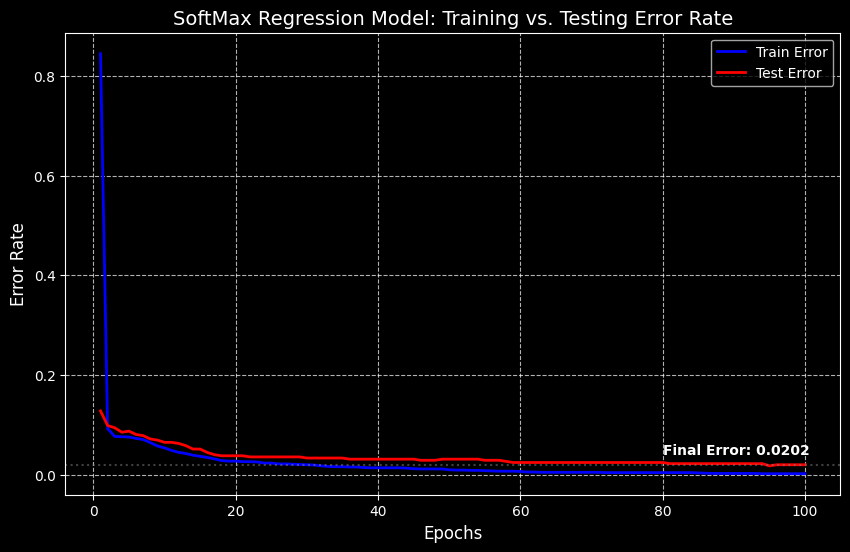

In [570]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), history_train_error, label='Train Error', color='blue', lw=2)
plt.plot(range(1, epochs + 1), history_test_error, label='Test Error', color='red', lw=2)

# Adding a horizontal line at the final test error for clarity
final_error = history_test_error[-1]
plt.axhline(y=final_error, color='gray', linestyle=':', alpha=0.5)
plt.text(len(history_test_error)-20, final_error + 0.02, f'Final Error: {final_error:.4f}', fontsize=10, fontweight='bold')

plt.title('SoftMax Regression Model: Training vs. Testing Error Rate', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [571]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Define the MLP model class based on your teacher's example
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPClassifier, self).__init__()
        # First hidden layer: Input -> 100 neurons
        self.hidden1 = nn.Linear(input_dim, 100)
        # Second hidden layer: 100 -> 50 neurons
        self.hidden2 = nn.Linear(100, 50)

        self.dropout = nn.Dropout(0.3)
        # Output layer: 50 -> Categories (5)
        self.linear = nn.Linear(50, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.dropout(x)
        x = torch.relu(self.hidden2(x))
        x = self.dropout(x)
        return self.linear(x)

# 2. Initialize the model
input_dim = X_train.shape[1]
output_dim = 5
model = MLPClassifier(input_dim, output_dim)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training Loop with History tracking
epochs = 100
history_train_error = []
history_test_error = []

print(f"{'Epoch':<10} | {'Loss':<10} | {'Train Error':<12} | {'Test Error':<12}")
print("-" * 50)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Track metrics for Section 17
    model.eval()
    with torch.no_grad():
        # Train Error
        _, train_pred = torch.max(outputs, 1)
        train_acc = (train_pred == y_train_tensor).sum().item() / y_train_tensor.size(0)

        # Test Error
        test_outputs = model(X_test_tensor)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)

        history_train_error.append(1 - train_acc)
        history_test_error.append(1 - test_acc)


        print(f"{epoch+1:<10} | {loss.item():<10.4f} | {history_train_error[-1]:<12.4f} | {history_test_error[-1]:<12.4f}")

# 4. Final Summary
final_accuracy = (1 - history_test_error[-1]) * 100
print(f"\nFinal MLP Accuracy: {final_accuracy:.2f}%")

Epoch      | Loss       | Train Error  | Test Error  
--------------------------------------------------
1          | 1.6105     | 0.8213       | 0.8472      
2          | 1.6094     | 0.8208       | 0.8472      
3          | 1.6067     | 0.8185       | 0.8472      
4          | 1.6040     | 0.8118       | 0.8472      
5          | 1.6010     | 0.7944       | 0.8472      
6          | 1.5979     | 0.7775       | 0.8337      
7          | 1.5947     | 0.7494       | 0.7281      
8          | 1.5905     | 0.7124       | 0.6337      
9          | 1.5857     | 0.6860       | 0.6022      
10         | 1.5803     | 0.6472       | 0.5978      
11         | 1.5753     | 0.6315       | 0.5708      
12         | 1.5697     | 0.5775       | 0.4652      
13         | 1.5622     | 0.5528       | 0.4135      
14         | 1.5567     | 0.5270       | 0.3910      
15         | 1.5501     | 0.5073       | 0.3753      
16         | 1.5392     | 0.4719       | 0.3663      
17         | 1.5330     | 0.450

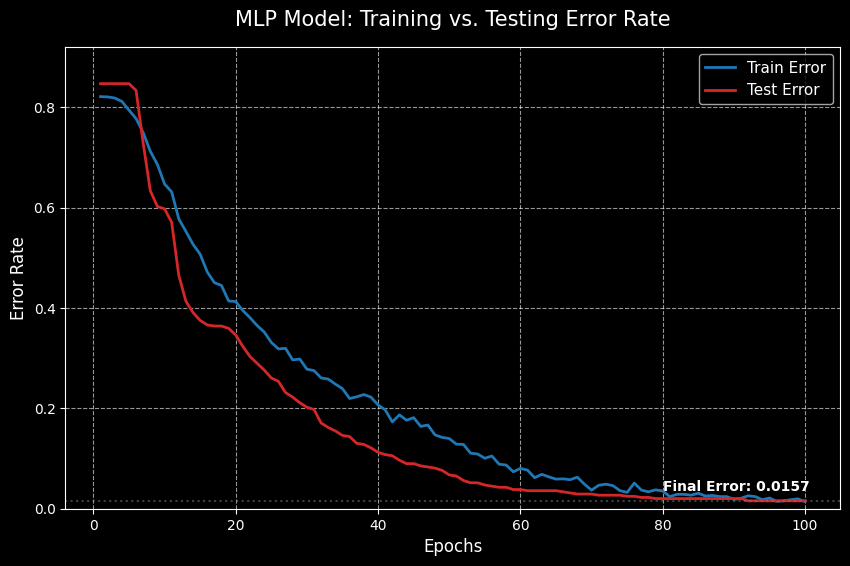

In [572]:
import matplotlib.pyplot as plt

# Create the plot for the MLP model (Section 17)
plt.figure(figsize=(10, 6))

# Plotting Train and Test error rates
plt.plot(range(1, len(history_train_error) + 1), history_train_error, label='Train Error', color='#1f77b4', lw=2)
plt.plot(range(1, len(history_test_error) + 1), history_test_error, label='Test Error', color='#d62728', lw=2)

# Customizing the graph for the report
plt.title('MLP Model: Training vs. Testing Error Rate', fontsize=15, pad=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding a horizontal line at the final test error for clarity
final_error = history_test_error[-1]
plt.axhline(y=final_error, color='gray', linestyle=':', alpha=0.5)
plt.text(len(history_test_error)-20, final_error + 0.02, f'Final Error: {final_error:.4f}', fontsize=10, fontweight='bold')

# Ensuring the Y-axis starts from 0 to show the full scale of improvement
plt.ylim(0, max(history_train_error[1:]) + 0.1)

# Save the plot as an image file for your PDF report
plt.savefig('mlp_error_graph.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()